# Calculate EarthCARE Orbits and ship tracking

Calculates and plot the sequence of EarthCARE orbits, assuming ton orbit zero it passes over the prime meridan.   By setting  t = t_op or t = t_cv one can select between either the operational 25 day orbit seq, or the cal/val 9-day orbit sequence.

The actual orbit will be within 0.5 deg (operational), or 1.3 deg (calval) of the prime meridian on some particular day.  This defines day 1, i.e., it could be 6 August.  Then the 12th of august would be day 7, and one would step through the sequence from that point accordingly.

In [1]:
from pathlib import Path
import geopy.distance
import cartopy.crs as ccrs
import cartopy.feature as cpf
from cartopy.io.shapereader import Reader
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import xarray
import json
from datetime import datetime

import intake
from adjustText import adjust_text

## Calculate the orbits in EC

In [2]:
c_earth = 40075.017      # circumference of earth at equator
spd     = 86400.         # seconds per day
kpd     = c_earth/360    # kilometers per degreen longitude at the equator

t_op = 5552.7
t_cv = 5554.3

n_op = 25
n_cv =  9

def offset(n,t):
    # copmute offset in degrees for the n'th orbit
    return (-c_earth * t/86400. * n/kpd)

In [3]:
def calc_orbits(scenario,wb=330.,eb=340.):
 
    if (scenario == 'operations'): 
        ndays = n_op
        t = t_op
    else:
        ndays = n_cv
        t = t_cv
        scenario = 'calval'
    
    orbits = ndays * spd/t
    print (f'Calculations for {scenario}: {orbits:3g} unique orbits\n')

    lons = np.zeros(int(orbits))
    days = np.zeros(int(orbits))
    
    for i, norbit in enumerate(np.arange(0,int(orbits))):
        lons[i] = offset(norbit,t)%360
        days[i] = norbit*t/86400 + 1
    
    lons_sel =[]
    days_sel = []
    for i,lon in enumerate(lons):
        if (lon > wb and lon < eb) : 
            lons_sel.append(lons[i]);
            days_sel.append(np.round(days[i]));
            
    return lons_sel,days_sel

## Calculate the Ship track

### Coordinates

### General

In [4]:
lonMin, lonMax = -60, -10
latMin, latMax = -10, 30

In [5]:
coordinates = {'mindeloNorth': 16.88, 'mindeloEast': -24.98, 
               'bcoNorth': 13.15, 'bcoEast': -59.42,
               'lasPalmasNorth': 28.15, 'lasPalmasEast': -15.42
              } 
latitudePirata = [-10,0,15,0,8,0,12,4,0,-6,0,-8,-14,-19,12,4,-6,21,20]
longitudePirata = [-10,-10,-38,-35,-38,0,-38,-38,-23,-10,-23,-30,-32,-34,-23,-23,8,-23,-38]

### Ship coordinates

In [6]:
coordinatesShip = {'turnNorth': 14.5, 
                   'turnCenterLat': 7.5, 
                   'turnSouth': 2.5, 
                   'turnSouthForLegWest': 5,
                   'turnSouthForPirata': -0.5,
                   'turnEast': -23, #Pirata at -23
                   'turnCenterLon': -32, #Pirata at -38
                   'turnWest': -47,
                  }

conversionKnKmH = 1.852

shipValues = {
              'averageSpeedKmH': 10*conversionKnKmH,
              'ctdTimePerDegLat': 1.5
             }

eastWestOffset = 0.4
northSouthOffset = 0.4

### Ship track

In [7]:

shipTrackTransitStart = [(coordinates['mindeloNorth'], coordinates['mindeloEast'])]

shipTrackLegEast = [ 
             (coordinatesShip['turnNorth'], coordinatesShip['turnEast']),
             (coordinatesShip['turnSouthForPirata'], coordinatesShip['turnEast']),
             (coordinatesShip['turnNorth'], coordinatesShip['turnEast']-eastWestOffset),
             (coordinatesShip['turnSouth'], coordinatesShip['turnEast']-eastWestOffset),
             (coordinatesShip['turnCenterLat'], coordinatesShip['turnEast']-eastWestOffset*2)
                   ]

shipTrackLegCenter = [
                      (coordinatesShip['turnCenterLat'], coordinatesShip['turnCenterLon']),
                      (coordinatesShip['turnNorth'], coordinatesShip['turnCenterLon']),
                      (coordinatesShip['turnSouth'], coordinatesShip['turnCenterLon']-eastWestOffset),
                      (coordinatesShip['turnNorth'], coordinatesShip['turnCenterLon']-eastWestOffset),
                      (coordinatesShip['turnCenterLat'], coordinatesShip['turnCenterLon']-eastWestOffset*2)            
                   ]

shipTrackLegWest = [
                    (coordinatesShip['turnCenterLat'], coordinatesShip['turnWest']),
                    (coordinatesShip['turnNorth'], coordinatesShip['turnWest']),
                    (coordinatesShip['turnSouthForLegWest'], coordinatesShip['turnWest']-eastWestOffset),
                    (coordinatesShip['turnCenterLat']+northSouthOffset, coordinatesShip['turnWest']-eastWestOffset),
                    (coordinatesShip['turnNorth']+northSouthOffset, coordinatesShip['turnWest']-eastWestOffset),
                   ]

shipTrackTransitEnd = [(coordinates['bcoNorth'], coordinates['bcoEast'])]

shipTrack = shipTrackTransitStart + shipTrackLegEast + shipTrackLegCenter + shipTrackLegWest + shipTrackTransitEnd
shipLat, shipLon  = zip(*shipTrack)

In [8]:
def calcShipTrackTime(shipTrack, startDate, shipSpeedKmH):
    
    shipTrackTime = [startDate]
    
    totalWorkingTimeH = 0
    totalStationTimeH = 0
    
    for shipInd in range(1, len(shipTrack)):
        coords_1 = shipTrack[shipInd]
        coords_2 = shipTrack[shipInd-1]
        
        # Travel time
        distanceKm = geopy.distance.geodesic(coords_1, coords_2).km
        travelTime = distanceKm/shipSpeedKmH
        timeH = travelTime
        
        # Station time (CTD time per latitudinal degree outside transit)
        if (coords_1 not in (shipTrackTransitStart + shipTrackTransitEnd)) & (coords_2 not in (shipTrackTransitStart + shipTrackTransitEnd)):
            latDistance = int(np.ceil(np.abs(coords_1[0]-coords_2[0])))
            stationTime = latDistance*shipValues['ctdTimePerDegLat']
            
            totalWorkingTimeH+=travelTime+stationTime
            totalStationTimeH+=stationTime
            timeH += stationTime
        
        shipIndTime = shipTrackTime[shipInd-1] + np.timedelta64(int(np.ceil(timeH)), 'h')

        shipTrackTime.append(shipIndTime)
        
    return shipTrackTime, np.timedelta64(int(totalWorkingTimeH), 'h'), np.timedelta64(int(totalStationTimeH), 'h')

## Ship location as a function of time

In [9]:
startDate = np.datetime64('2023-08-10T12:00')
shipTrackTime, totalWorkingTimeShip, totalStationTimeShip = calcShipTrackTime(shipTrack, startDate, shipValues['averageSpeedKmH'])
print(f"""Number of working days: {np.timedelta64(totalWorkingTimeShip, 'D')}, 
Total station time {np.timedelta64(totalStationTimeShip, 'D')}""")

Number of working days: 40 days, 
Total station time 7 days


In [10]:
track_dic = {'track_lon': shipLon, 'track_lat': shipLat, 'track_time': shipTrackTime}

# Save the dictionary to a JSON file
with open('track.json', 'w') as json_file:
    json.dump(track_dic, json_file, default=str)

### Plot the EC trajectory and ship track

Calculations for operations: 389 unique orbits



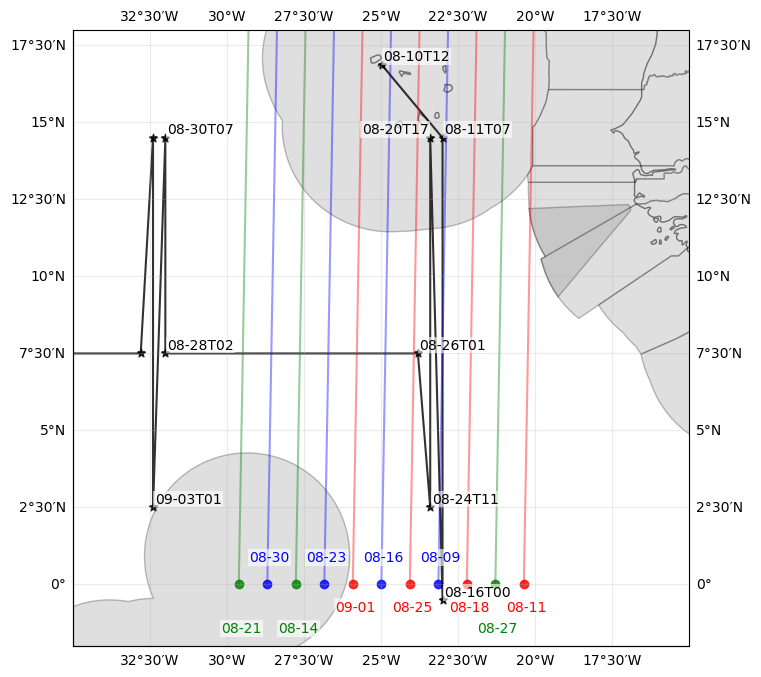

In [19]:
##calculate EC orbits
lon_ec,time_ec = calc_orbits('operations')
time_ec = np.array(time_ec+np.datetime64('2024-08-08','D').astype(int), dtype='datetime64[D]')
lat_ec = np.zeros(len(lon_ec))

plt.figure(figsize = (20, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)


time = datetime(2001, 8, 31, 12, 0, 0)
#time = random.choice(ds.time).values
        

#plt.scatter(longitudePirata, latitudePirata, color = 'k', label = 'PIRATA', alpha = 0.5)
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], marker = '+')

plt.xlabel("Longitude [°E]")
plt.ylabel("Latitude [°N]")


ax.set_xlim(-35,-15)
ax.set_ylim(-2, 18)

plt.scatter(shipLon,shipLat, alpha=0.8, color = 'k', marker = '*')
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k')

plt.scatter(lon_ec[0::3],lat_ec[0::3], alpha=0.8, color = 'b', marker = 'o')
for i in range(len(lon_ec[0::3])):
    plt.plot([lon_ec[0::3][i]-360,lon_ec[0::3][i]-360+(18*np.tan(1/180*np.pi))],
             [0,18], color = 'b',alpha=0.4)

plt.scatter(lon_ec[1::3],lat_ec[1::3], alpha=0.8, color = 'r', marker = 'o')
for i in range(len(lon_ec[1::3])):
    plt.plot([lon_ec[1::3][i]-360,lon_ec[1::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'r',alpha=0.4)

plt.scatter(lon_ec[2::3],lat_ec[2::3], alpha=0.8, color = 'g', marker = 'o')
for i in range(len(lon_ec[2::3])):
    plt.plot([lon_ec[2::3][i]-360,lon_ec[2::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'g',alpha=0.4)
    
texts = []
for x, y, s in zip(shipLon[:-8], shipLat[:-8], shipTrackTime[:-8]):
    texts.append(plt.text(x, y, str(s)[5:-3], color = 'k', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts, longitudePirata+list(shipLon), latitudePirata+list(shipLat), force_text = (1.5, 0.5))

texts2 = []
for x, y, s in zip(np.array(lon_ec[0::3])-360, lat_ec[0::3], time_ec[0::3]):
    texts2.append(plt.text(x-0.6, y+0.6, str(s)[5:], color = 'b', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts2, force_text = (1.5, 1))

texts3 = []
for x, y, s in zip(np.array(lon_ec[1::3])-360, lat_ec[1::3], time_ec[1::3]):
    texts3.append(plt.text(x-0.6, y-1, str(s)[5:], color = 'r', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts3, force_text = (1.5, 1))

texts4 = []
for x, y, s in zip(np.array(lon_ec[2::3])-360, lat_ec[2::3], time_ec[2::3]):
    texts4.append(plt.text(x-0.6, y-1.7, str(s)[5:], color = 'g', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts4, force_text = (1.5, 1))

sn.despine()

Calculations for operations: 389 unique orbits



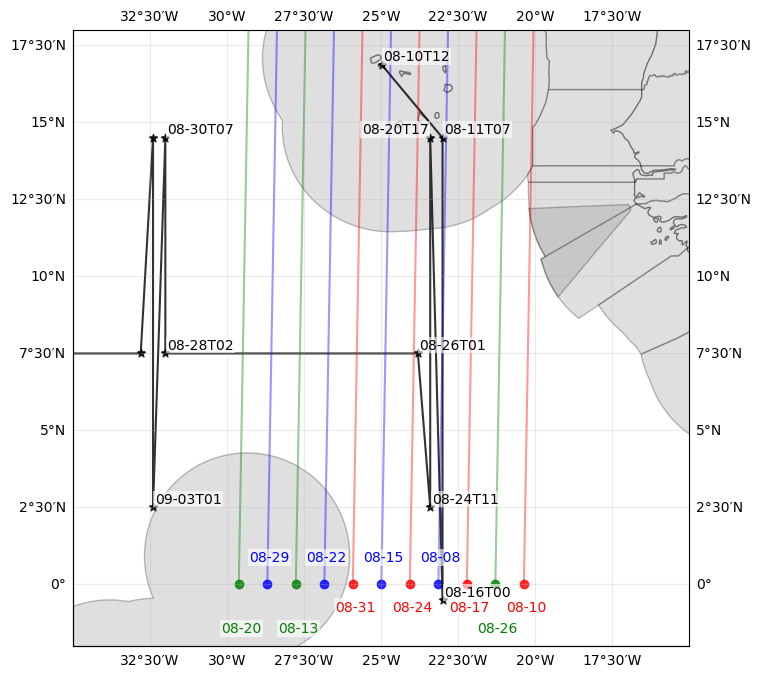

In [14]:
##calculate EC orbits
lon_ec,time_ec = calc_orbits('operations')
time_ec = np.array(time_ec+np.datetime64('2024-08-07','D').astype(int), dtype='datetime64[D]')
lat_ec = np.zeros(len(lon_ec))

plt.figure(figsize = (20, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)


time = datetime(2001, 8, 31, 12, 0, 0)
#time = random.choice(ds.time).values
        

#plt.scatter(longitudePirata, latitudePirata, color = 'k', label = 'PIRATA', alpha = 0.5)
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], marker = '+')

plt.xlabel("Longitude [°E]")
plt.ylabel("Latitude [°N]")


ax.set_xlim(-35,-15)
ax.set_ylim(-2, 18)

plt.scatter(shipLon,shipLat, alpha=0.8, color = 'k', marker = '*')
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k')

plt.scatter(lon_ec[0::3],lat_ec[0::3], alpha=0.8, color = 'b', marker = 'o')
for i in range(len(lon_ec[0::3])):
    plt.plot([lon_ec[0::3][i]-360,lon_ec[0::3][i]-360+(18*np.tan(1/180*np.pi))],
             [0,18], color = 'b',alpha=0.4)

plt.scatter(lon_ec[1::3],lat_ec[1::3], alpha=0.8, color = 'r', marker = 'o')
for i in range(len(lon_ec[1::3])):
    plt.plot([lon_ec[1::3][i]-360,lon_ec[1::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'r',alpha=0.4)

plt.scatter(lon_ec[2::3],lat_ec[2::3], alpha=0.8, color = 'g', marker = 'o')
for i in range(len(lon_ec[2::3])):
    plt.plot([lon_ec[2::3][i]-360,lon_ec[2::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'g',alpha=0.4)
    
texts = []
for x, y, s in zip(shipLon[:-8], shipLat[:-8], shipTrackTime[:-8]):
    texts.append(plt.text(x, y, str(s)[5:-3], color = 'k', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts, longitudePirata+list(shipLon), latitudePirata+list(shipLat), force_text = (1.5, 0.5))

texts2 = []
for x, y, s in zip(np.array(lon_ec[0::3])-360, lat_ec[0::3], time_ec[0::3]):
    texts2.append(plt.text(x-0.6, y+0.6, str(s)[5:], color = 'b', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts2, force_text = (1.5, 1))

texts3 = []
for x, y, s in zip(np.array(lon_ec[1::3])-360, lat_ec[1::3], time_ec[1::3]):
    texts3.append(plt.text(x-0.6, y-1, str(s)[5:], color = 'r', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts3, force_text = (1.5, 1))

texts4 = []
for x, y, s in zip(np.array(lon_ec[2::3])-360, lat_ec[2::3], time_ec[2::3]):
    texts4.append(plt.text(x-0.6, y-1.7, str(s)[5:], color = 'g', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts4, force_text = (1.5, 1))

sn.despine()

Calculations for operations: 389 unique orbits



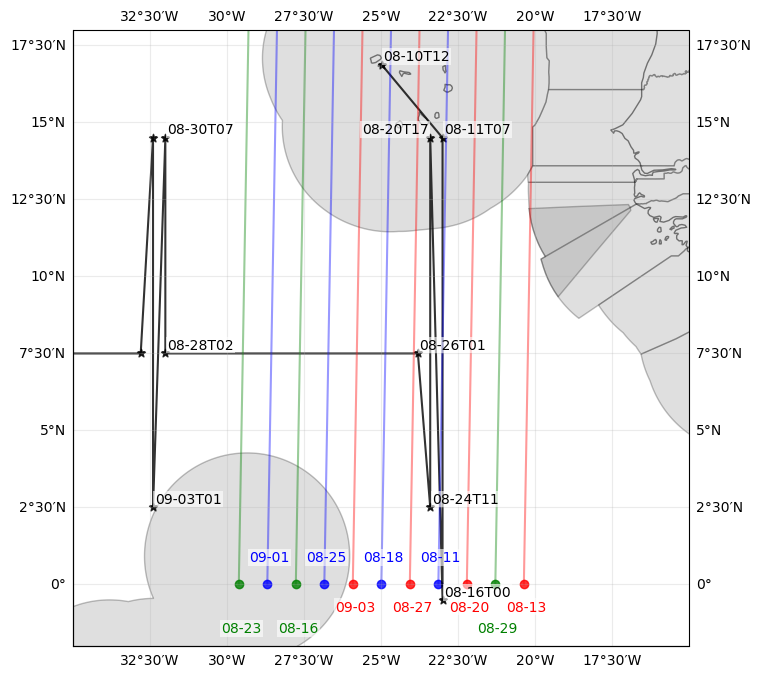

In [16]:
##calculate EC orbits
lon_ec,time_ec = calc_orbits('operations')
time_ec = np.array(time_ec+np.datetime64('2024-08-10','D').astype(int), dtype='datetime64[D]')
lat_ec = np.zeros(len(lon_ec))

plt.figure(figsize = (20, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)


time = datetime(2001, 8, 31, 12, 0, 0)
#time = random.choice(ds.time).values
        

#plt.scatter(longitudePirata, latitudePirata, color = 'k', label = 'PIRATA', alpha = 0.5)
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], marker = '+')

plt.xlabel("Longitude [°E]")
plt.ylabel("Latitude [°N]")


ax.set_xlim(-35,-15)
ax.set_ylim(-2, 18)

plt.scatter(shipLon,shipLat, alpha=0.8, color = 'k', marker = '*')
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k')

plt.scatter(lon_ec[0::3],lat_ec[0::3], alpha=0.8, color = 'b', marker = 'o')
for i in range(len(lon_ec[0::3])):
    plt.plot([lon_ec[0::3][i]-360,lon_ec[0::3][i]-360+(18*np.tan(1/180*np.pi))],
             [0,18], color = 'b',alpha=0.4)

plt.scatter(lon_ec[1::3],lat_ec[1::3], alpha=0.8, color = 'r', marker = 'o')
for i in range(len(lon_ec[1::3])):
    plt.plot([lon_ec[1::3][i]-360,lon_ec[1::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'r',alpha=0.4)

plt.scatter(lon_ec[2::3],lat_ec[2::3], alpha=0.8, color = 'g', marker = 'o')
for i in range(len(lon_ec[2::3])):
    plt.plot([lon_ec[2::3][i]-360,lon_ec[2::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'g',alpha=0.4)
    
texts = []
for x, y, s in zip(shipLon[:-8], shipLat[:-8], shipTrackTime[:-8]):
    texts.append(plt.text(x, y, str(s)[5:-3], color = 'k', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts, longitudePirata+list(shipLon), latitudePirata+list(shipLat), force_text = (1.5, 0.5))

texts2 = []
for x, y, s in zip(np.array(lon_ec[0::3])-360, lat_ec[0::3], time_ec[0::3]):
    texts2.append(plt.text(x-0.6, y+0.6, str(s)[5:], color = 'b', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts2, force_text = (1.5, 1))

texts3 = []
for x, y, s in zip(np.array(lon_ec[1::3])-360, lat_ec[1::3], time_ec[1::3]):
    texts3.append(plt.text(x-0.6, y-1, str(s)[5:], color = 'r', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts3, force_text = (1.5, 1))

texts4 = []
for x, y, s in zip(np.array(lon_ec[2::3])-360, lat_ec[2::3], time_ec[2::3]):
    texts4.append(plt.text(x-0.6, y-1.7, str(s)[5:], color = 'g', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts4, force_text = (1.5, 1))

sn.despine()

Calculations for operations: 389 unique orbits



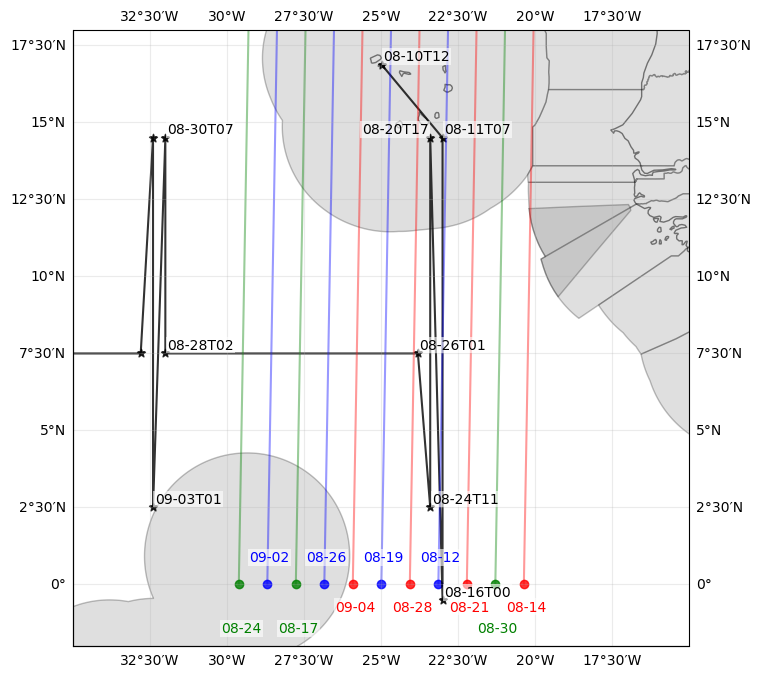

In [18]:
##calculate EC orbits
lon_ec,time_ec = calc_orbits('operations')
time_ec = np.array(time_ec+np.datetime64('2024-08-11','D').astype(int), dtype='datetime64[D]')
lat_ec = np.zeros(len(lon_ec))

plt.figure(figsize = (20, 8))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(alpha=0.5)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)

#Add the shapefiles
direc_shp, file_shp = '../TrackPlanning/EEZ_land_union_v3_202003/', 'EEZ_Land_v3_202030.shp'
shape_feature = cpf.ShapelyFeature(Reader(direc_shp+file_shp).geometries(),
                               ccrs.PlateCarree(), edgecolor='black', facecolor='grey', alpha = 0.25)
ax.add_feature(shape_feature,zorder=1)


time = datetime(2001, 8, 31, 12, 0, 0)
#time = random.choice(ds.time).values
        

#plt.scatter(longitudePirata, latitudePirata, color = 'k', label = 'PIRATA', alpha = 0.5)
plt.scatter(coordinates['bcoEast'], coordinates['bcoNorth'], marker = '+')

plt.xlabel("Longitude [°E]")
plt.ylabel("Latitude [°N]")


ax.set_xlim(-35,-15)
ax.set_ylim(-2, 18)

plt.scatter(shipLon,shipLat, alpha=0.8, color = 'k', marker = '*')
p1 = plt.plot(shipLon,shipLat, alpha=0.8, color = 'k')

plt.scatter(lon_ec[0::3],lat_ec[0::3], alpha=0.8, color = 'b', marker = 'o')
for i in range(len(lon_ec[0::3])):
    plt.plot([lon_ec[0::3][i]-360,lon_ec[0::3][i]-360+(18*np.tan(1/180*np.pi))],
             [0,18], color = 'b',alpha=0.4)

plt.scatter(lon_ec[1::3],lat_ec[1::3], alpha=0.8, color = 'r', marker = 'o')
for i in range(len(lon_ec[1::3])):
    plt.plot([lon_ec[1::3][i]-360,lon_ec[1::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'r',alpha=0.4)

plt.scatter(lon_ec[2::3],lat_ec[2::3], alpha=0.8, color = 'g', marker = 'o')
for i in range(len(lon_ec[2::3])):
    plt.plot([lon_ec[2::3][i]-360,lon_ec[2::3][i]-360+(18*np.tan(1/180*np.pi))],[0,18], color = 'g',alpha=0.4)
    
texts = []
for x, y, s in zip(shipLon[:-8], shipLat[:-8], shipTrackTime[:-8]):
    texts.append(plt.text(x, y, str(s)[5:-3], color = 'k', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts, longitudePirata+list(shipLon), latitudePirata+list(shipLat), force_text = (1.5, 0.5))

texts2 = []
for x, y, s in zip(np.array(lon_ec[0::3])-360, lat_ec[0::3], time_ec[0::3]):
    texts2.append(plt.text(x-0.6, y+0.6, str(s)[5:], color = 'b', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts2, force_text = (1.5, 1))

texts3 = []
for x, y, s in zip(np.array(lon_ec[1::3])-360, lat_ec[1::3], time_ec[1::3]):
    texts3.append(plt.text(x-0.6, y-1, str(s)[5:], color = 'r', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts3, force_text = (1.5, 1))

texts4 = []
for x, y, s in zip(np.array(lon_ec[2::3])-360, lat_ec[2::3], time_ec[2::3]):
    texts4.append(plt.text(x-0.6, y-1.7, str(s)[5:], color = 'g', backgroundcolor='white', bbox=dict(facecolor='white', alpha=0.6, linewidth=0, pad=1.0)))
adjust_text(texts4, force_text = (1.5, 1))

sn.despine()